In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

try:
    from xgboost import XGBRegressor
    xgb_available = True
except Exception:
    xgb_available = False

INPUT_FILE = "Goals & Assist .xlsx"
RANDOM_STATE = 42
TEST_SIZE = 0.20
N_ITER = 30
CV = 3


In [5]:
df = pd.read_excel(INPUT_FILE)
df

,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals,Assists,Goals Per 90,Assists Per 90,Non-Penalty Goals Per 90,xG Per 90,xAG Per 90,npxG Per 90
0,AT,32,38,38,3371,37.5,29,18,0.77,0.48,0.53,0.67,0.38,0.49
1,DF,33,37,37,3330,37.0,3,1,0.08,0.03,0.08,0.06,0.02,0.06
2,MT,22,37,37,3160,35.1,0,4,0.00,0.11,0.00,0.03,0.09,0.03
3,MT,25,35,30,2599,28.9,5,5,0.17,0.17,0.17,0.10,0.16,0.10
4,DF,25,31,30,2560,28.4,1,2,0.04,0.07,0.04,0.06,0.03,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2269,MT,21,18,2,371,4.1,1,2,0.24,0.49,0.24,0.43,0.26,0.43
2270,"MT,DF",31,20,1,273,3.0,0,0,0.00,0.00,0.00,0.00,0.02,0.00
2271,AT,26,6,1,108,1.2,0,0,0.00,0.00,0.00,0.28,0.15,0.28
2272,GB,23,1,0,12,0.1,0,0,0.00,0.00,0.00,0.00,0.00,0.00


In [4]:
df.columns = (
    df.columns
    .str.replace(r"[^A-Za-z0-9_]", "", regex=True)
    .str.replace(" ", "_")
)

df.head()


,Position,Age,MatchesPlayed,Starts,Minutes,90sPlayed,Goals,Assists,GoalsPer90,AssistsPer90,NonPenaltyGoalsPer90,xGPer90,xAGPer90,npxGPer90
0,AT,32,38,38,3371,37.5,29,18,0.77,0.48,0.53,0.67,0.38,0.49
1,DF,33,37,37,3330,37.0,3,1,0.08,0.03,0.08,0.06,0.02,0.06
2,MT,22,37,37,3160,35.1,0,4,0.00,0.11,0.00,0.03,0.09,0.03
3,MT,25,35,30,2599,28.9,5,5,0.17,0.17,0.17,0.10,0.16,0.10
4,DF,25,31,30,2560,28.4,1,2,0.04,0.07,0.04,0.06,0.03,0.06


In [6]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
display(df.info())
print("\nDescribe:")
display(df.describe(include="all"))
print("\nMissing Values:")
df.isnull().sum()


Shape: (2274, 14)

Columns: ['Position', 'Age', 'Matches Played', 'Starts', 'Minutes', '90s Played', 'Goals', 'Assists', 'Goals Per 90', 'Assists Per 90', 'Non-Penalty Goals Per 90', 'xG Per 90', 'xAG Per 90', 'npxG Per 90']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274 entries, 0 to 2273
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Position                  2274 non-null   object 
 1   Age                       2274 non-null   int64  
 2   Matches Played            2274 non-null   int64  
 3   Starts                    2274 non-null   int64  
 4   Minutes                   2274 non-null   int64  
 5   90s Played                2274 non-null   float64
 6   Goals                     2274 non-null   int64  
 7   Assists                   2274 non-null   int64  
 8   Goals Per 90              2274 non-null   float64
 9   Assists Per 90            2274 non-null   float64
 

None


Describe:


,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals,Assists,Goals Per 90,Assists Per 90,Non-Penalty Goals Per 90,xG Per 90,xAG Per 90,npxG Per 90
count,2274,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000
unique,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,DF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,25.094987,19.226913,14.313105,1278.278804,14.202331,1.566403,1.096746,0.096486,0.063602,0.089943,0.115391,0.075853,0.108672
std,NaN,4.465810,11.519163,11.512175,987.117422,10.968616,3.124944,1.880588,0.182532,0.104213,0.173435,0.185577,0.112750,0.177073
min,NaN,15.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,22.000000,9.000000,3.000000,360.250000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.010000
50%,NaN,25.000000,20.000000,12.000000,1105.500000,12.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.040000,0.050000
75%,NaN,28.000000,30.000000,25.000000,2150.000000,23.900000,2.000000,1.000000,0.120000,0.100000,0.110000,0.140000,0.110000,0.140000



Missing Values:


Position                    0
Age                         0
Matches Played              0
Starts                      0
Minutes                     0
90s Played                  0
Goals                       0
Assists                     0
Goals Per 90                0
Assists Per 90              0
Non-Penalty Goals Per 90    0
xG Per 90                   0
xAG Per 90                  0
npxG Per 90                 0
dtype: int64

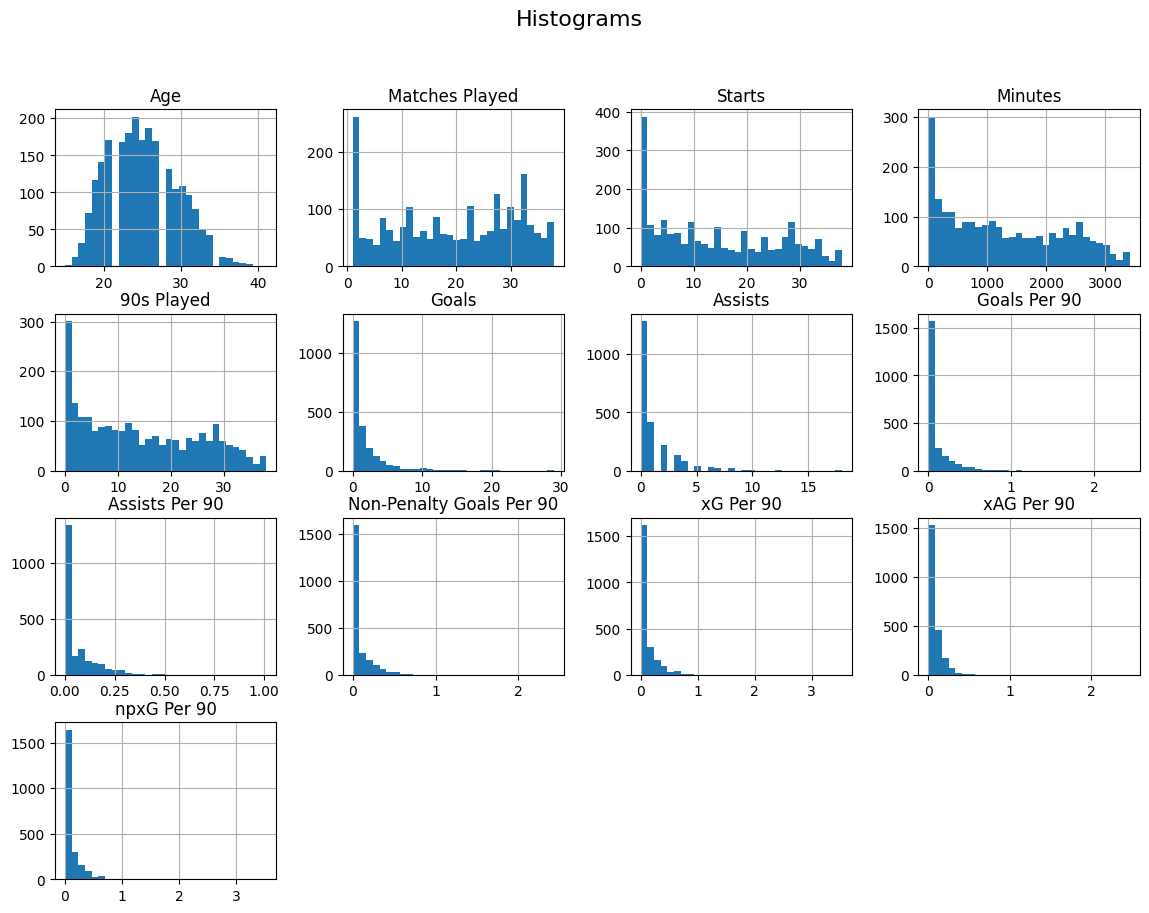

In [7]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

df[numeric_cols].hist(figsize=(14,10), bins=30)
plt.suptitle("Histograms", fontsize=16)
plt.show()


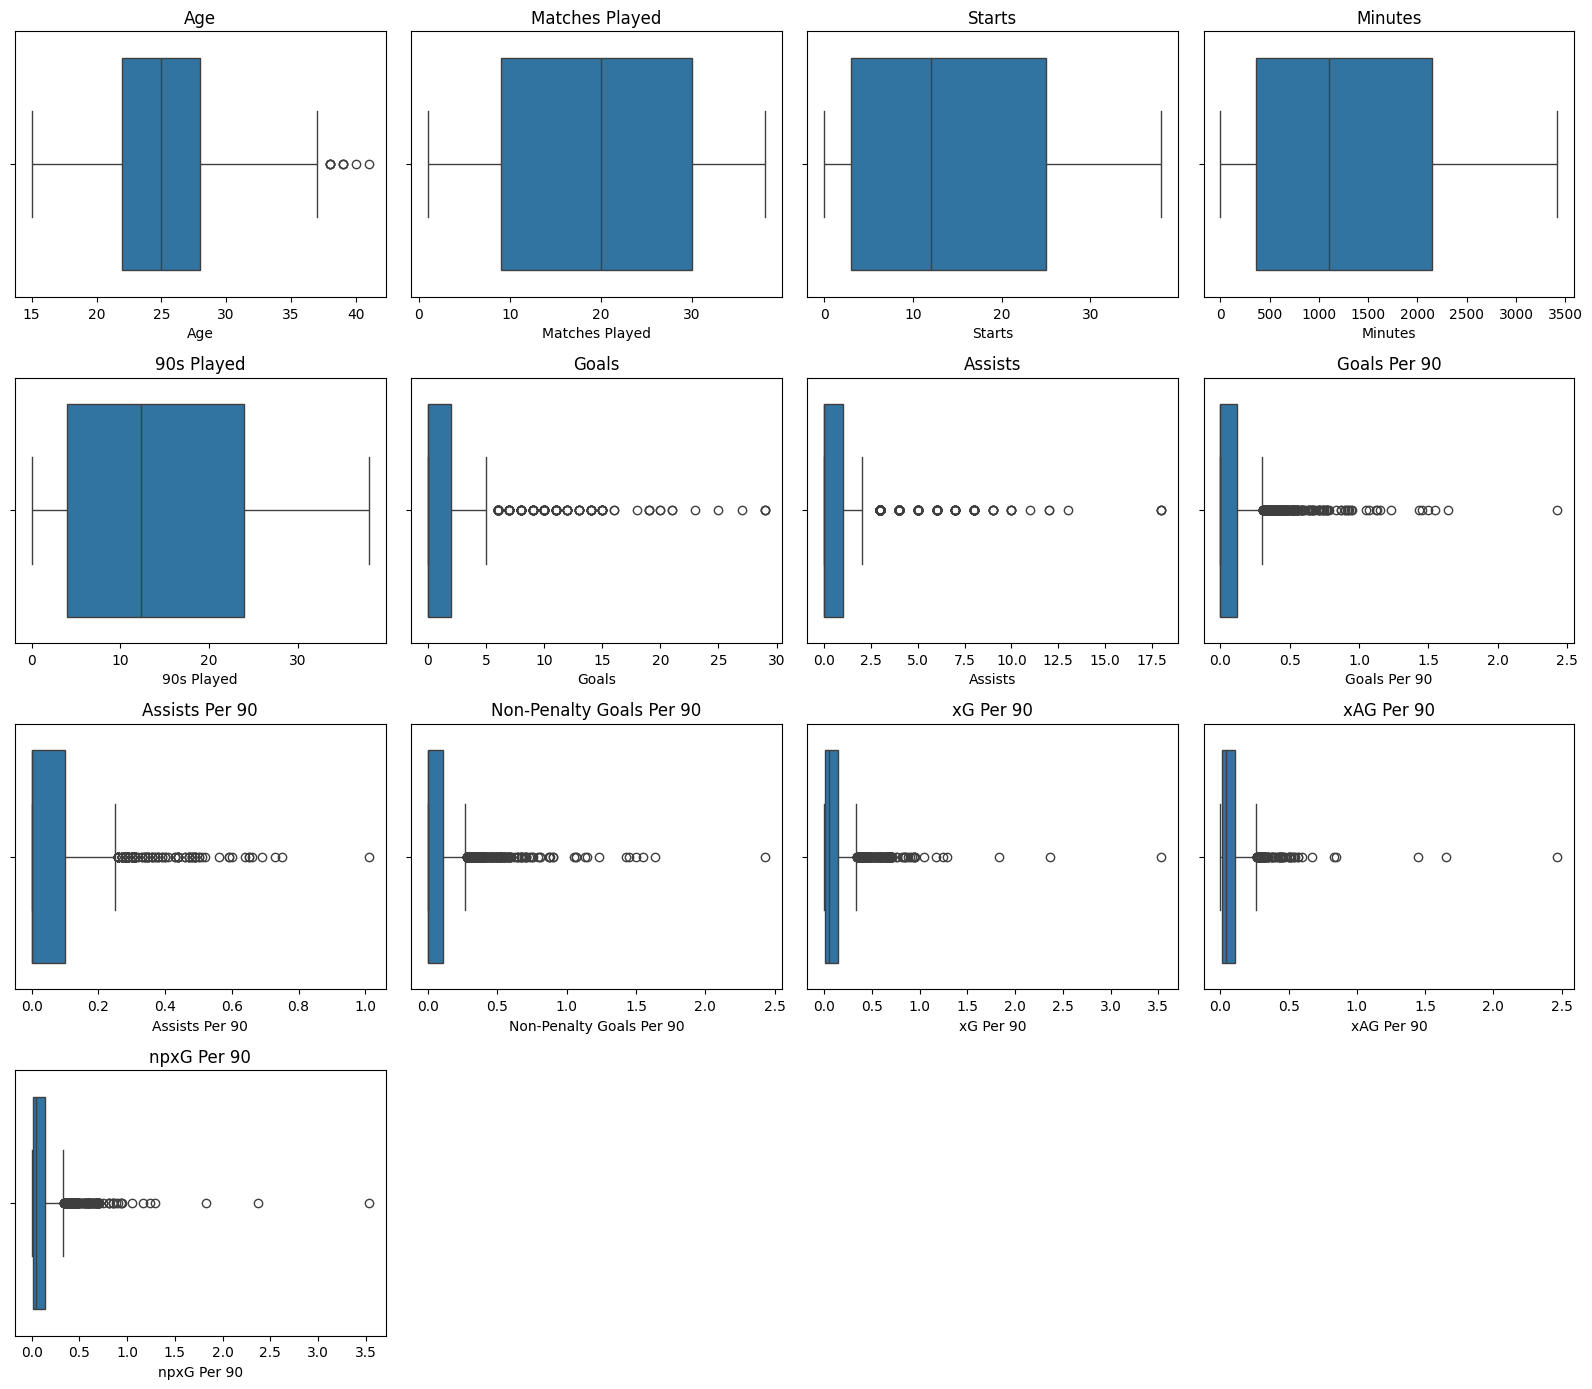

In [8]:
cols = 4
rows = (len(numeric_cols) // cols) + (1 if len(numeric_cols) % cols else 0)

plt.figure(figsize=(16, rows * 3.5))
for i, c in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=df[c])
    plt.title(c)

plt.tight_layout()
plt.show()


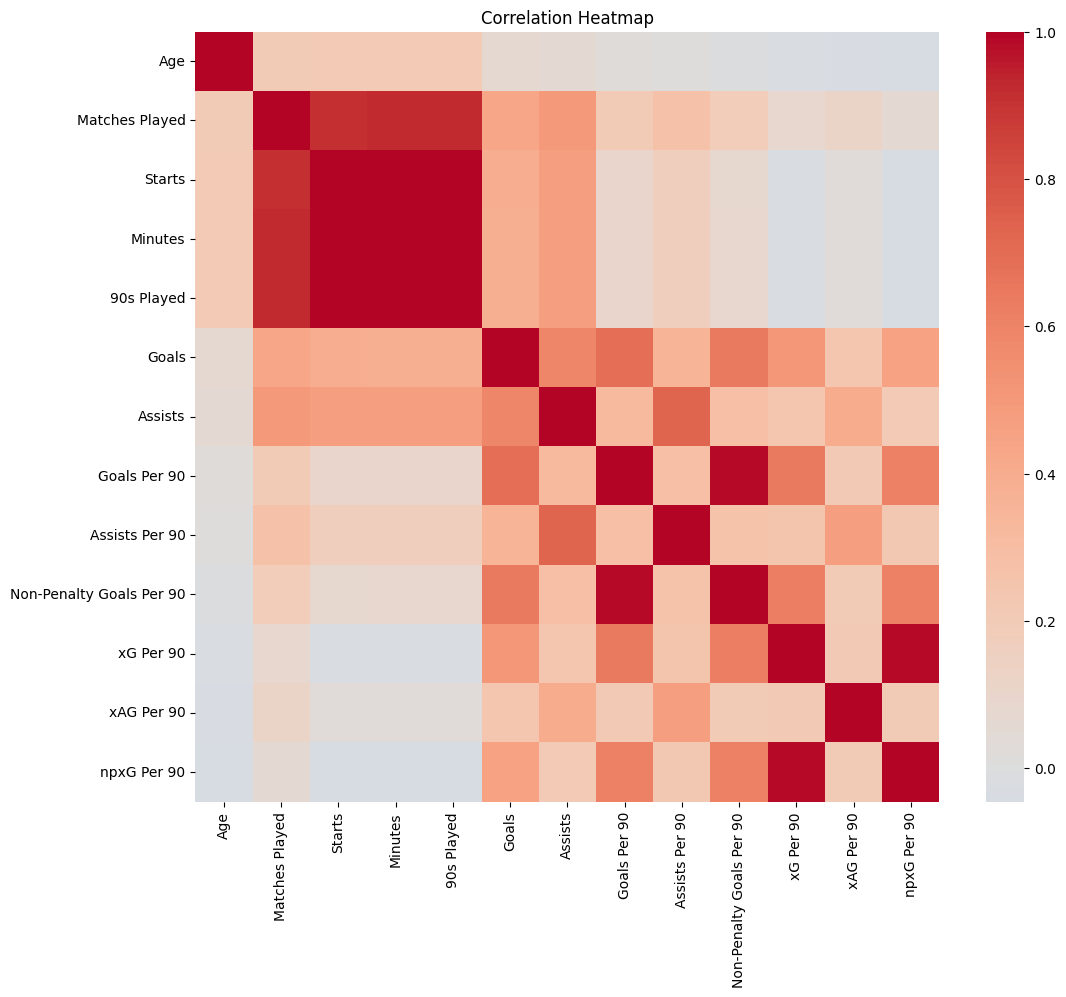

In [9]:
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


In [10]:
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in categorical_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

df.head()


,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals,Assists,Goals Per 90,Assists Per 90,Non-Penalty Goals Per 90,xG Per 90,xAG Per 90,npxG Per 90
0,AT,32,38,38,3371,37.5,29,18,0.77,0.48,0.53,0.67,0.38,0.49
1,DF,33,37,37,3330,37.0,3,1,0.08,0.03,0.08,0.06,0.02,0.06
2,MT,22,37,37,3160,35.1,0,4,0.00,0.11,0.00,0.03,0.09,0.03
3,MT,25,35,30,2599,28.9,5,5,0.17,0.17,0.17,0.10,0.16,0.10
4,DF,25,31,30,2560,28.4,1,2,0.04,0.07,0.04,0.06,0.03,0.06


In [11]:
df_clean = df.copy()
mask = pd.Series(True, index=df_clean.index)

for c in numeric_cols:
    q1 = df_clean[c].quantile(0.25)
    q3 = df_clean[c].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = mask & df_clean[c].between(lower, upper)

before_rows = df_clean.shape[0]
df_clean = df_clean[mask]
after_rows = df_clean.shape[0]

print("Rows removed:", before_rows - after_rows)
df = df_clean.copy()
df.head()


Rows removed: 631


,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals,Assists,Goals Per 90,Assists Per 90,Non-Penalty Goals Per 90,xG Per 90,xAG Per 90,npxG Per 90
1,DF,33,37,37,3330,37.0,3,1,0.08,0.03,0.08,0.06,0.02,0.06
4,DF,25,31,30,2560,28.4,1,2,0.04,0.07,0.04,0.06,0.03,0.06
6,DF,30,33,29,2482,27.6,0,1,0.00,0.04,0.00,0.04,0.17,0.04
7,GB,31,28,28,2508,27.9,0,0,0.00,0.00,0.00,0.00,0.02,0.00
13,GB,25,10,10,900,10.0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


In [12]:
df.to_csv("cleaned_all_features.csv", index=False)
df.head()


,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals,Assists,Goals Per 90,Assists Per 90,Non-Penalty Goals Per 90,xG Per 90,xAG Per 90,npxG Per 90
1,DF,33,37,37,3330,37.0,3,1,0.08,0.03,0.08,0.06,0.02,0.06
4,DF,25,31,30,2560,28.4,1,2,0.04,0.07,0.04,0.06,0.03,0.06
6,DF,30,33,29,2482,27.6,0,1,0.00,0.04,0.00,0.04,0.17,0.04
7,GB,31,28,28,2508,27.9,0,0,0.00,0.00,0.00,0.00,0.02,0.00
13,GB,25,10,10,900,10.0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


In [13]:
target_goals = "Goals"
target_assists = "Assists"

categorical_cols = ["Position"] if "Position" in df.columns else []
df.head()


,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals,Assists,Goals Per 90,Assists Per 90,Non-Penalty Goals Per 90,xG Per 90,xAG Per 90,npxG Per 90
1,DF,33,37,37,3330,37.0,3,1,0.08,0.03,0.08,0.06,0.02,0.06
4,DF,25,31,30,2560,28.4,1,2,0.04,0.07,0.04,0.06,0.03,0.06
6,DF,30,33,29,2482,27.6,0,1,0.00,0.04,0.00,0.04,0.17,0.04
7,GB,31,28,28,2508,27.9,0,0,0.00,0.00,0.00,0.00,0.02,0.00
13,GB,25,10,10,900,10.0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


In [14]:
X = df.drop(columns=["Goals", "Assists"])
y = df["Goals"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X.head()


,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals Per 90,Assists Per 90,Non-Penalty Goals Per 90,xG Per 90,xAG Per 90,npxG Per 90
1,DF,33,37,37,3330,37.0,0.08,0.03,0.08,0.06,0.02,0.06
4,DF,25,31,30,2560,28.4,0.04,0.07,0.04,0.06,0.03,0.06
6,DF,30,33,29,2482,27.6,0.00,0.04,0.00,0.04,0.17,0.04
7,GB,31,28,28,2508,27.9,0.00,0.00,0.00,0.00,0.02,0.00
13,GB,25,10,10,900,10.0,0.00,0.00,0.00,0.00,0.00,0.00


In [15]:
ohe = OneHotEncoder(drop="first", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[("ohe", ohe, categorical_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False
)


In [16]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)

param_dist_rf = {
    "model__n_estimators": randint(200, 1000),
    "model__max_depth": randint(3, 20),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2", None]
}

pipe_rf = Pipeline([("preprocessor", preprocessor), ("model", rf)])

rf_search_goals = RandomizedSearchCV(
    pipe_rf, param_distributions=param_dist_rf,
    n_iter=N_ITER, cv=CV, scoring="r2",
    n_jobs=-1, random_state=RANDOM_STATE
)

rf_search_goals.fit(X_train, y_train)
rf_search_goals.best_estimator_


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Position'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 RandomForestRegressor(max_depth=11, max_features=None,
                                       min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=800, random_state=42))])

In [17]:
rf_best = rf_search_goals.best_estimator_
preds = rf_best.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

print("RF Goals — MAE:", mae)
print("RF Goals — RMSE:", rmse)
print("RF Goals — R2:", r2)


RF Goals — MAE: 0.027874411587652477
RF Goals — RMSE: 0.10705809183055955
RF Goals — R2: 0.9890948015269367


In [18]:
joblib.dump(rf_best, "rf_model_goals.pkl")

['rf_model_goals.pkl']

In [19]:
preprocessor.fit(X)
full_feature_names = (
    list(preprocessor.named_transformers_["ohe"].get_feature_names_out(categorical_cols))
    + [c for c in X.columns if c not in categorical_cols]
)

importances = rf_best.named_steps["model"].feature_importances_

fi_goals = pd.DataFrame({
    "Feature": full_feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

fi_goals.head(10)


,Feature,Importance
10,Goals Per 90,0.782065
8,Minutes,0.067681
9,90s Played,0.058907
7,Starts,0.041346
12,Non-Penalty Goals Per 90,0.040850
6,Matches Played,0.005235
14,xAG Per 90,0.001819
5,Age,0.000686
13,xG Per 90,0.000449
11,Assists Per 90,0.000313


In [20]:
X = df.drop(columns=["Assists", "Goals"])
y = df["Assists"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X.head()


,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals Per 90,Assists Per 90,Non-Penalty Goals Per 90,xG Per 90,xAG Per 90,npxG Per 90
1,DF,33,37,37,3330,37.0,0.08,0.03,0.08,0.06,0.02,0.06
4,DF,25,31,30,2560,28.4,0.04,0.07,0.04,0.06,0.03,0.06
6,DF,30,33,29,2482,27.6,0.00,0.04,0.00,0.04,0.17,0.04
7,GB,31,28,28,2508,27.9,0.00,0.00,0.00,0.00,0.02,0.00
13,GB,25,10,10,900,10.0,0.00,0.00,0.00,0.00,0.00,0.00


In [21]:
ohe = OneHotEncoder(drop="first", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[("ohe", ohe, categorical_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False
)


In [22]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)

param_dist_rf = {
    "model__n_estimators": randint(200, 1000),
    "model__max_depth": randint(3, 20),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2", None]
}

pipe_rf = Pipeline([("preprocessor", preprocessor), ("model", rf)])

rf_search_assists = RandomizedSearchCV(
    pipe_rf, param_distributions=param_dist_rf,
    n_iter=N_ITER, cv=CV, scoring="r2",
    n_jobs=-1, random_state=RANDOM_STATE
)

rf_search_assists.fit(X_train, y_train)
rf_search_assists.best_estimator_


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Position'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 RandomForestRegressor(max_depth=11, max_features=None,
                                       min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=800, random_state=42))])

In [23]:
rf_best = rf_search_assists.best_estimator_
preds = rf_best.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

print("RF Assists — MAE:", mae)
print("RF Assists — RMSE:", rmse)
print("RF Assists — R2:", r2)


RF Assists — MAE: 0.008470636537980768
RF Assists — RMSE: 0.043399160710968325
RF Assists — R2: 0.9950466365555122


In [24]:
joblib.dump(rf_best, "rf_model_assists.pkl")


['rf_model_assists.pkl']